# Autoencoder for matrix imputation

In some cases our data contains missing values. In this exercise we will implement an autoencoder to impute the missing values. 

<img src="ae_arch.png" width=600 height=400 />

As shown in the figure, the autoencoder receives as input the incomplete data and retrieves an imputed version after training.

The autoencoder is trained in a similar way as usual, but we need to masked the NaN values in the loss function 

$\mathcal{L} = \sum_{i,j: (i,j) \in S} (X_{ij} - \hat{X}_{ij})^{2}$. Notice that if your pixels are normalized between 0 and 1 you can also use binary cross entropy. 

The set $S$ are all the $(i,j)$ pairs with known entries.

Things to consider: 
- You have to mask some entries of the loss. Thus, you need to find the NaN entries and use their indices. Also make sure you use a loss that allows you to mask entries.
- The NaN values in your input matrix should be transformed to zeros since the layers in torch does not handle NaN entries. 

In [18]:
import numpy as np
import torchvision
from torchvision import transforms
import pandas as pd
import sklearn
import torch
from PIL import Image, ImageFilter 

import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset
import seaborn as sns
import pandas as pd

from tensorflow.keras.datasets import mnist

In [19]:
class MnistDigitsM():   
    def __init__(self, n_samples = 5000, perc_mask = 0.1):
        (train_images, Y_train), (test_images, Y_test) = mnist.load_data()
        train_images = train_images[:n_samples]
        inputs = train_images.reshape((n_samples, 784))/255.
        inputs = inputs[:n_samples]
        self.labels = Y_train[:n_samples]
        self.true_data = inputs.copy()
        inputs_flat = inputs.ravel()
        ind = np.arange(len(inputs_flat))
        ind_mask = np.random.choice(ind, int(ind.shape[0] * perc_mask))
        inputs_flat[ind_mask] = np.nan
        # mask perc_mask of data 
        self.data_train = inputs
        self.test_ind = np.where(np.isnan(inputs))

In [20]:
data = MnistDigitsM(perc_mask = 0.9)

In [21]:
data.data_train

array([[nan, nan,  0., ...,  0., nan,  0.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan,  0.],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0., nan, ..., nan,  0., nan]])

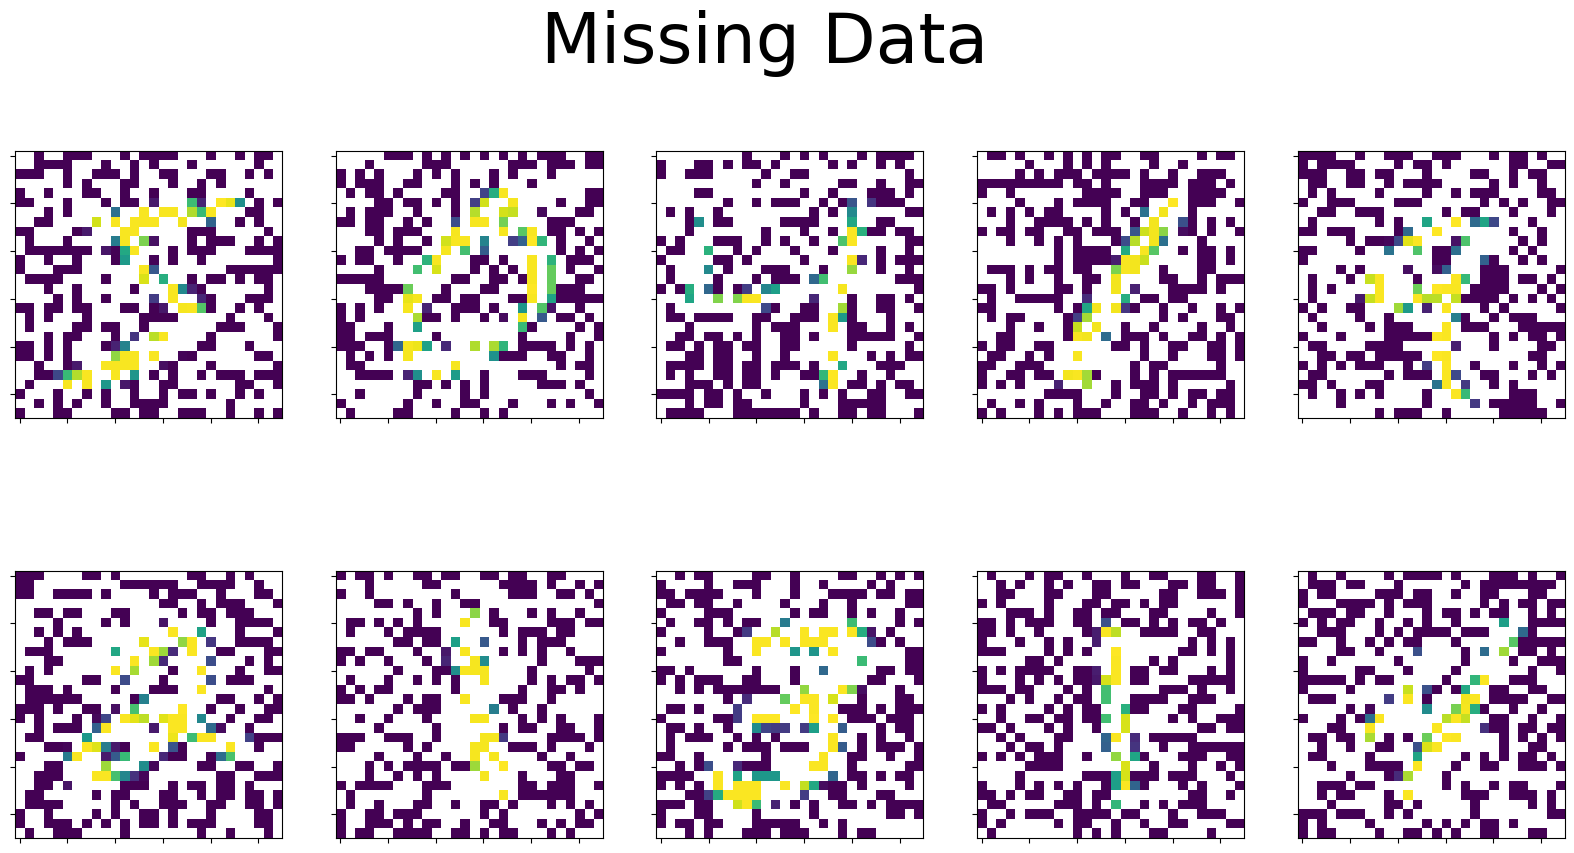

In [22]:
def plot_images(images, img_prow, width, length, title = None):
    '''
    Takes images as rows in numpy arrays
    img_prow is the number of images per row.
    '''
    rows = np.ceil(len(images)/img_prow).astype(int)
    fig, (a1) = plt.subplots(rows, img_prow, figsize=(20, 10))
    fig.suptitle(title, size = 50)
    images = images.reshape(len(images), width, length)      
    row_ind = 0
    col_ind = 0
    
    for k in range(len(images)):
        a1[row_ind, col_ind].imshow(images[k,:,:])
        a1[row_ind, col_ind].set_xticklabels([])
        a1[row_ind, col_ind].set_yticklabels([])
        col_ind += 1
        if col_ind > img_prow - 1:
            col_ind  = 0
            row_ind += 1 
    plt.show()
    
plot_images(data.data_train[:10], 5, 28, 28, title = "Missing Data")

### Sklearn methods 

Let's try some simple methods available in sklearn to compare with our final solution

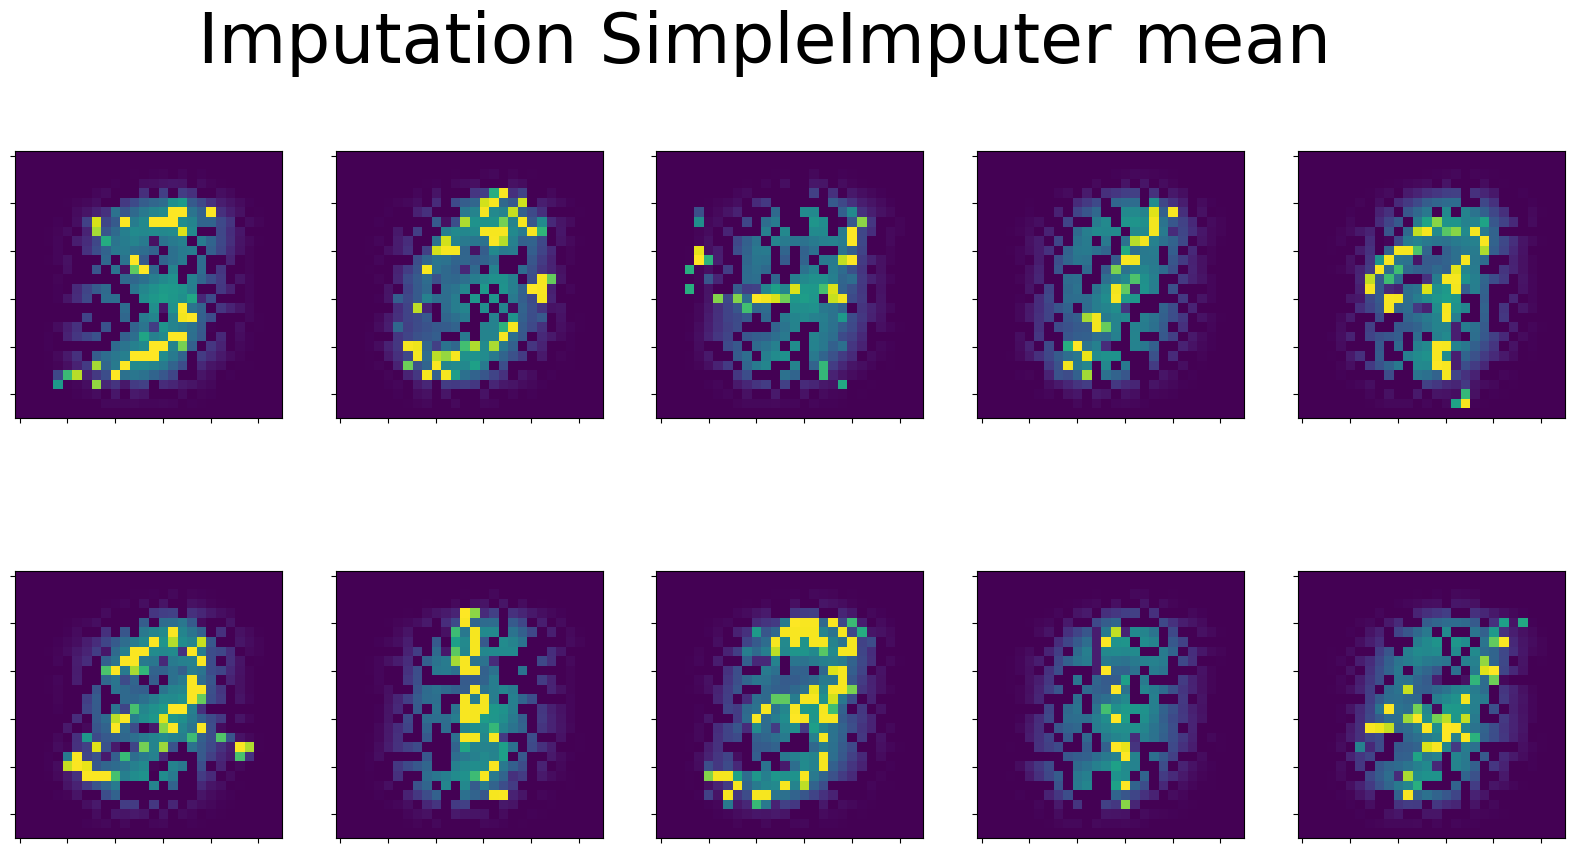

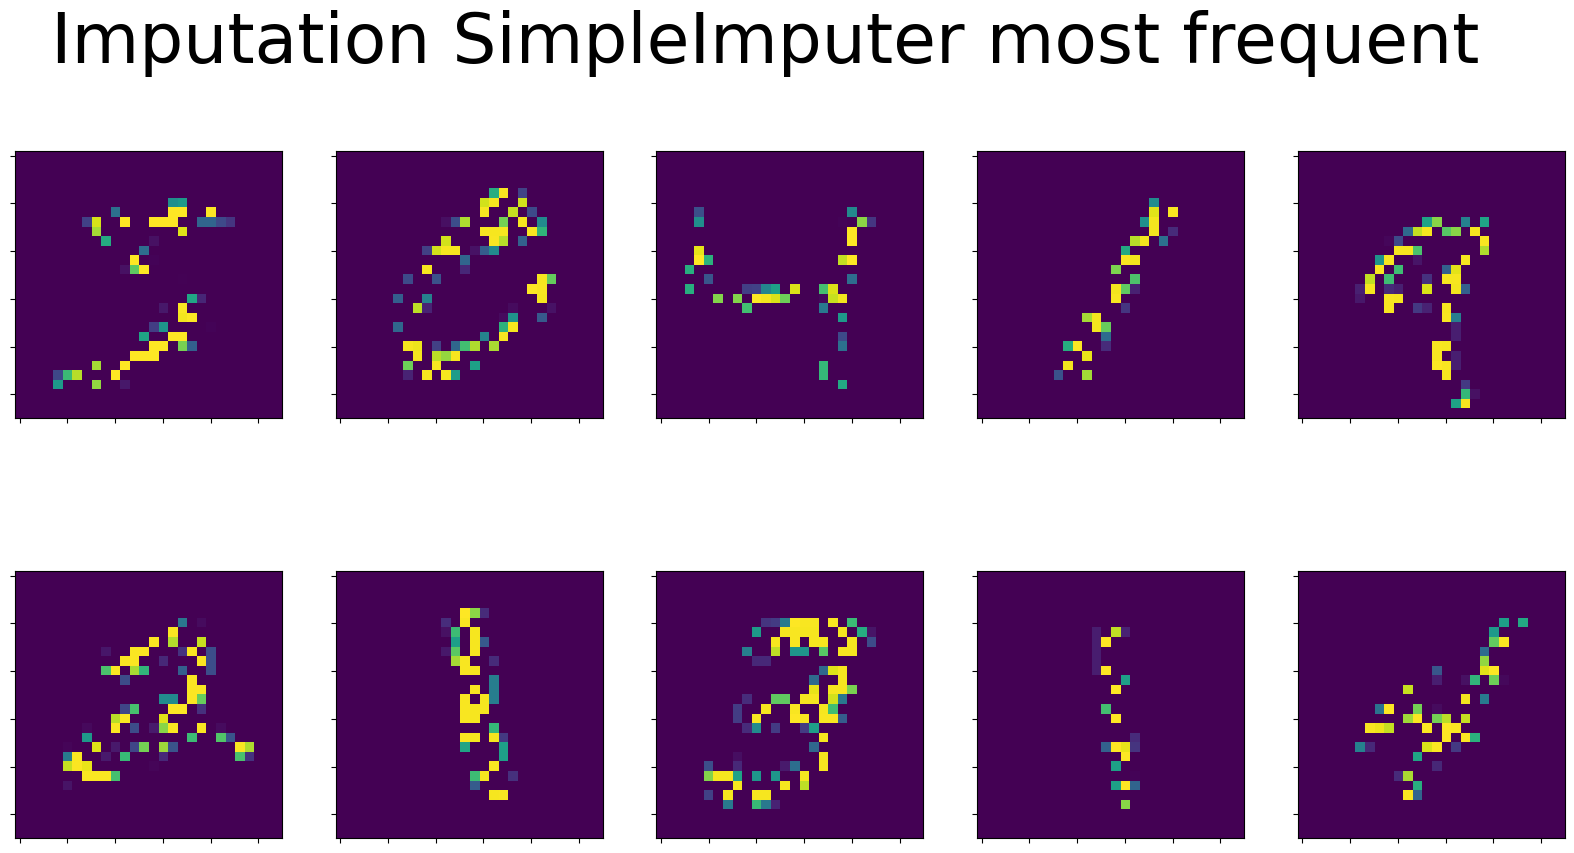

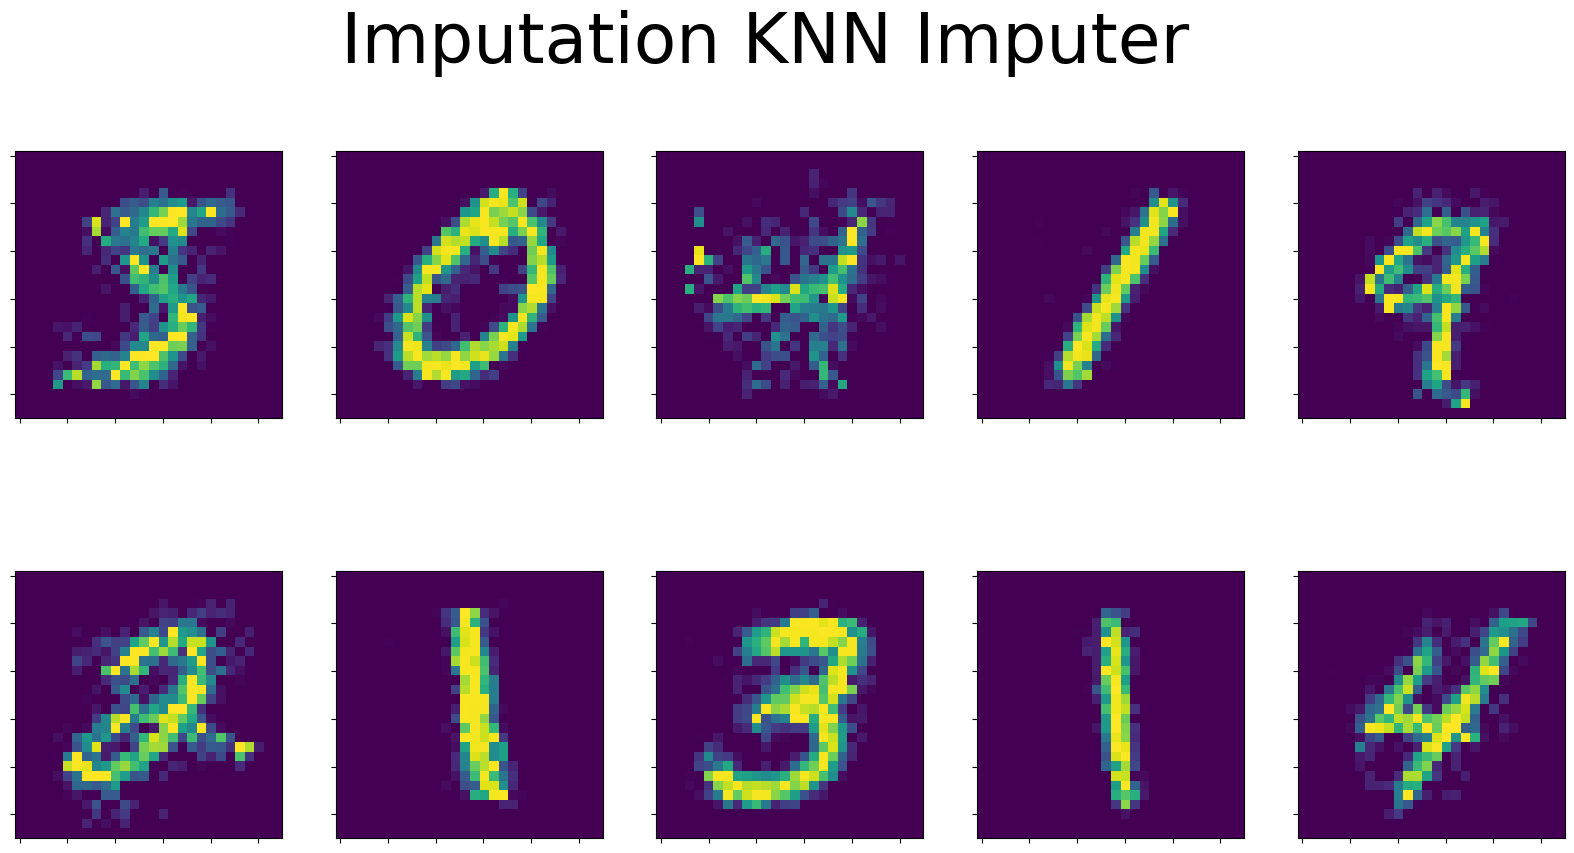

In [32]:
from sklearn.impute import SimpleImputer, KNNImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
rec = imp.fit_transform(data.data_train)
plot_images(rec[:10], 5, 28, 28, title = "Imputation SimpleImputer mean")

imp = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")
rec = imp.fit_transform(data.data_train)
plot_images(rec[:10], 5, 28, 28, title = "Imputation SimpleImputer most frequent")


rec = KNNImputer(n_neighbors=10, weights="uniform").fit_transform(data.data_train)
plot_images(rec[:10], 5, 28, 28, title = "Imputation KNN Imputer")

In [23]:
class dataset(Dataset):
        def __init__(self, X, mask):
            self.X = X
            self.mask = mask
        def __len__(self):
            return len(self.X)   
        def __getitem__(self, idx):
            return self.X[idx], self.mask[idx]

### Create the model architecture: 
 - Your AE_module should be able to take any number of hidden layers 
 - You could use the nn.Sequential module of pytorch and get a module that looks as:

In [ ]:
# model.torch_module

In [24]:
class AE_module(nn.Module):
    def __init__(self, input_dim, hidden_dims, z_dim):
        super().__init__()
        '''***Complete the init method and the forward pass***
        The input_dim is the number of features of your data
        hidden_dim is a list containing the inner layers dimensions as specified above
        z_dim is the dimension of the bottleneck 
        '''
        layers = [nn.Flatten()]
        for k in range(len(hidden_dims)):
            if k == 0:
                layers.append(nn.Linear(input_dim, hidden_dims[k]))
                layers.append(nn.ReLU())
            elif k == len(hidden_dims) - 1:
                layers.append(nn.Linear(hidden_dims[k-1], z_dim))
                layers.append(nn.ReLU())
            else:
                layers.append(nn.Linear(hidden_dims[k-1], hidden_dims[k]))
                layers.append(nn.ReLU()) 

        for k in range(len(hidden_dims)):
            if k == 0:
                layers.append(nn.Linear(z_dim, hidden_dims[-1]))
                layers.append(nn.ReLU())
            elif k == len(hidden_dims) - 1:
                layers.append(nn.Linear(hidden_dims[-k], input_dim))
                layers.append(nn.Sigmoid())
            else:
                layers.append(nn.Linear(hidden_dims[-k], hidden_dims[-k-1]))
                layers.append(nn.ReLU())


        self.model = nn.Sequential(*layers)

    def forward(self, x):
        ''' ***Implement the forward pass***
        '''
        return self.model(x)

In [25]:
class AE_MI():
    """Autoencoder for Matrix Imputation"""

    def __init__(self,  lr=1e-3, 
                 epochs=1000, 
                 batch_size=128, 
                 weight_decay=0,
                 hidden_dims=[300, 200, 100], 
                 z_size = 50):
        
        # The learning rate for the optimizer 
        self.lr = lr
        
        # number of epochs and batch size
        self.epochs = epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        
        # dimension of the hidden layers
        self.hidden_dims = hidden_dims  
        # dimension of the bottleneck 
        self.z_size  = z_size   

        '''***define the reconstruction criterion***'''

        self.loss_func = nn.BCELoss()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def fit(self, X):
        

        X = torch.Tensor(X)
        
        # Find zero values to mask to compute the loss
        indices = torch.where(~torch.isnan(X))
        mask_m = torch.zeros(X.shape)
        mask_m[indices[0], indices[1]] = 1
        self.mask = mask_m
        X = torch.nan_to_num_(X)
        


        input_size = X.shape[1]
      
        # Call the AE_module implemented above 
        self.torch_module = AE_module(input_dim=input_size,
                                    hidden_dims=self.hidden_dims,
                                    z_dim=self.z_size)

            
        # define optimizer
        self.optimizer = torch.optim.Adam(self.torch_module.parameters(),
                                          lr=self.lr,
                                          weight_decay=self.weight_decay)
        
        
        
        # Train AE
        self.torch_module.to(self.device)
        self.torch_module.train()
        
        # The dataset class is built with the mask matrix and the data matrix X. 
        data_set = dataset(X, self.mask)
        # Dataloader 
        self.loader = torch.utils.data.DataLoader(data_set, batch_size=self.batch_size, shuffle=False)
        
        
        for epoch in range(self.epochs):
            for batch in self.loader:
                self.optimizer.zero_grad()
                self.train_body(batch)
                self.optimizer.step()
            if epoch % 100 == 0:
                # Just to print the loss and visualize the reconstruction 
                print(f"Epoch {epoch} out of {self.epochs} ==== Loss: {self.loss.item()}")
                rec = self.transform(data.data_train)
                plot_images(rec[:10], 5, 28, 28, title = f"Imputation AE after {epoch} epochs")
                

    def train_body(self, batch):
        data, mask = batch
        mask = mask.to(self.device)
        data = data.to(self.device) 
        x_hat = self.torch_module(data)
        self.apply_loss(data, x_hat, mask)

    def apply_loss(self, x, x_hat, mask):
        '''***Implement the loss***
        '''
        ind = mask.bool()
        loss = self.loss_func(x_hat[ind], x[ind])
        loss.backward()
        self.loss = loss

    
    def transform(self, X):
        self.torch_module.eval()
        X = torch.Tensor(np.array(X)).to(self.device)
        X = torch.nan_to_num_(X)
        x_rec = self.torch_module(X)
        self.torch_module.train()
        return x_rec.detach().cpu().numpy()

### Now we are ready to create the model and fit it

In [26]:
model = AE_MI(epochs = 1000, z_size = 100, hidden_dims = [200, 100])

Epoch 0 out of 1000 ==== Loss: 0.27934694290161133


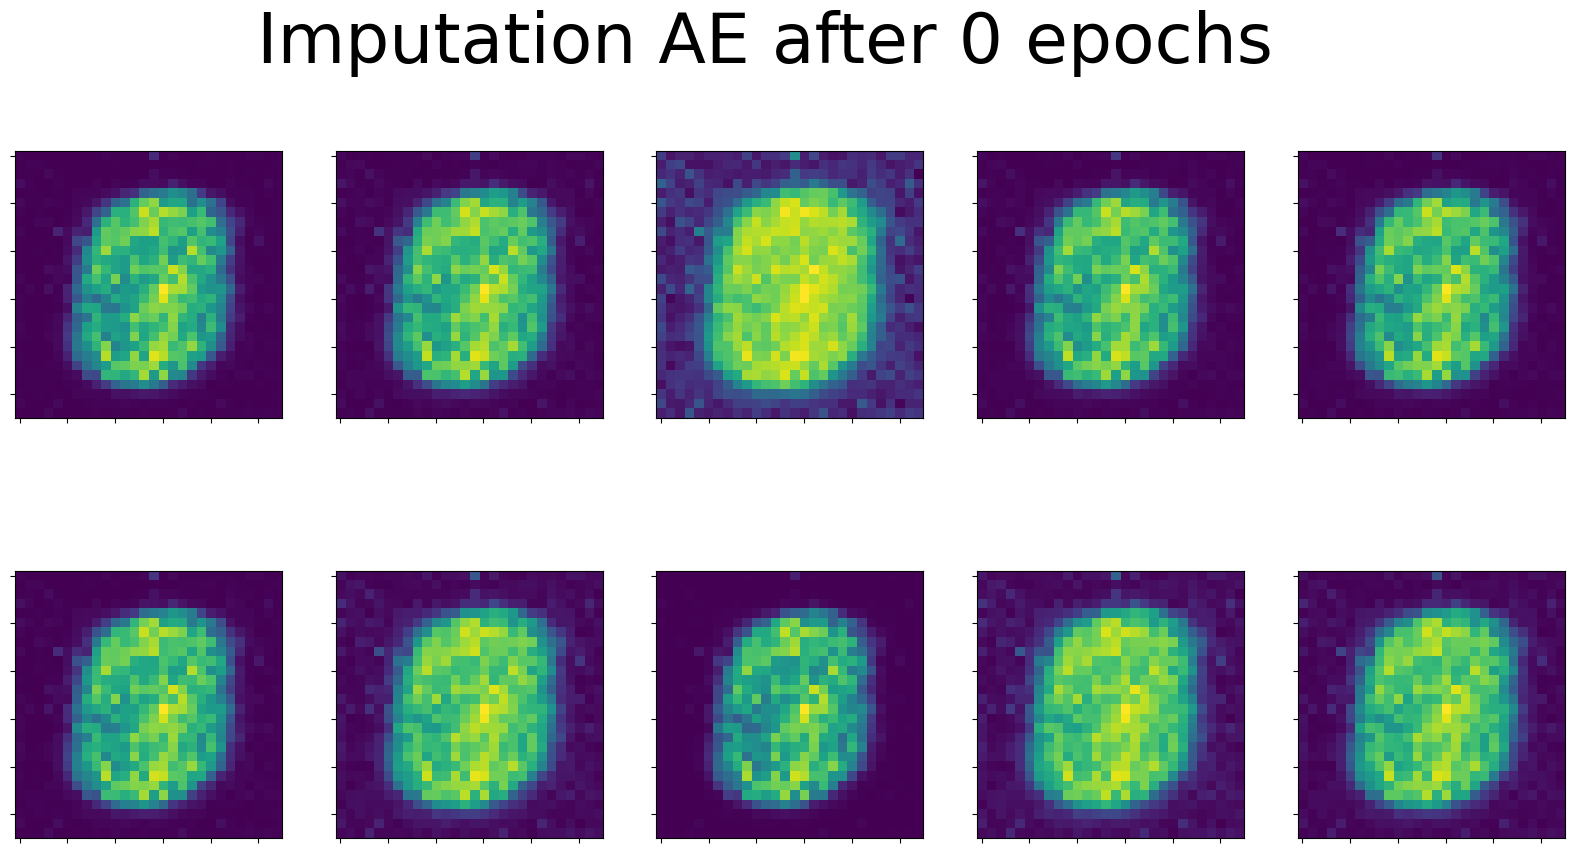

Epoch 100 out of 1000 ==== Loss: 0.06402488797903061


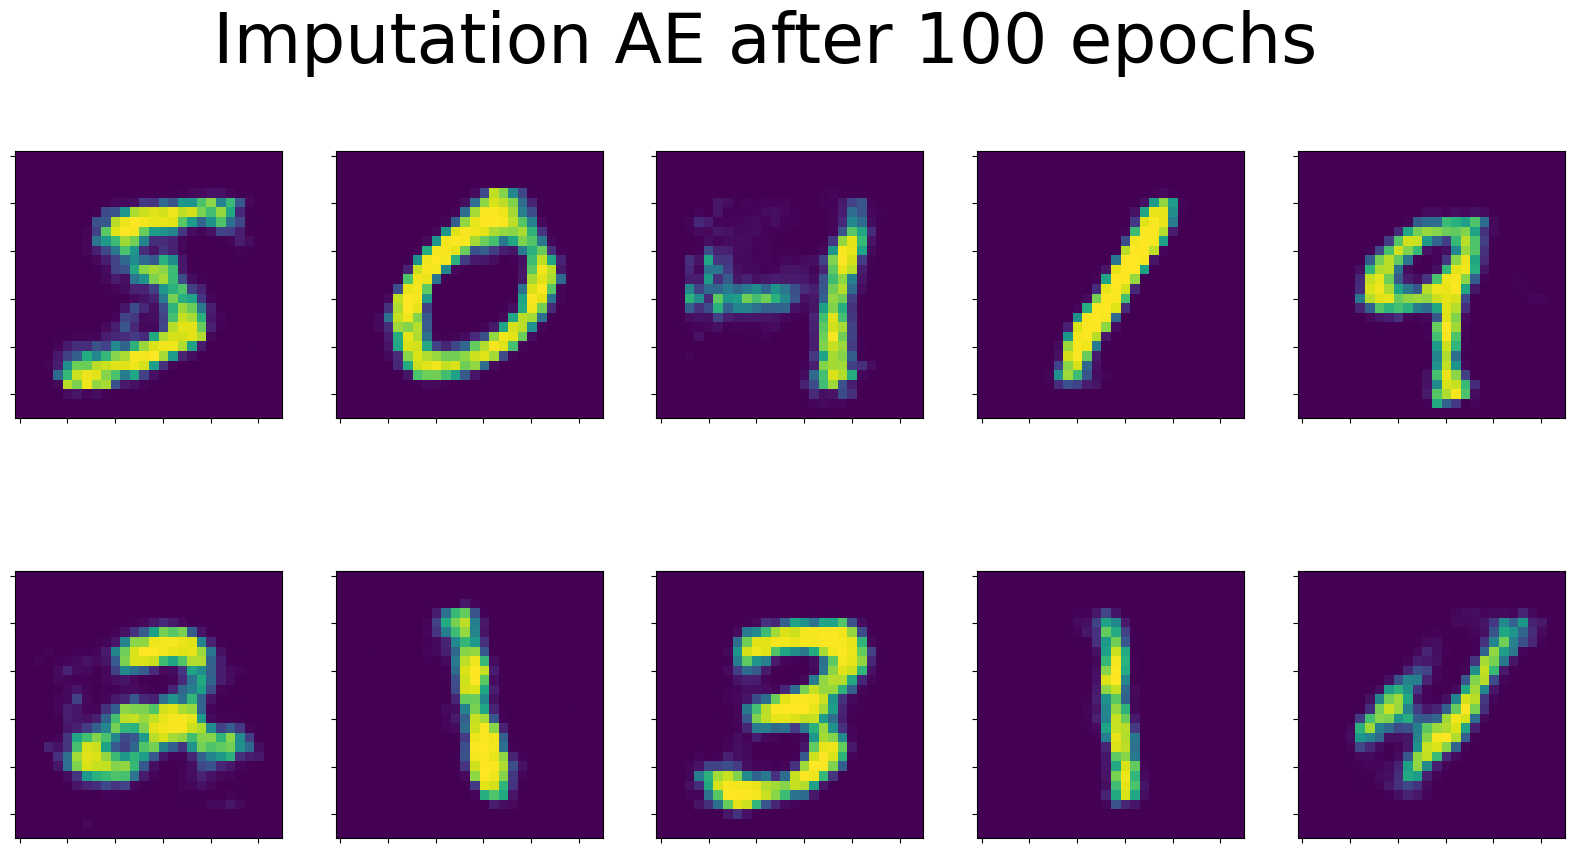

Epoch 200 out of 1000 ==== Loss: 0.06162802875041962


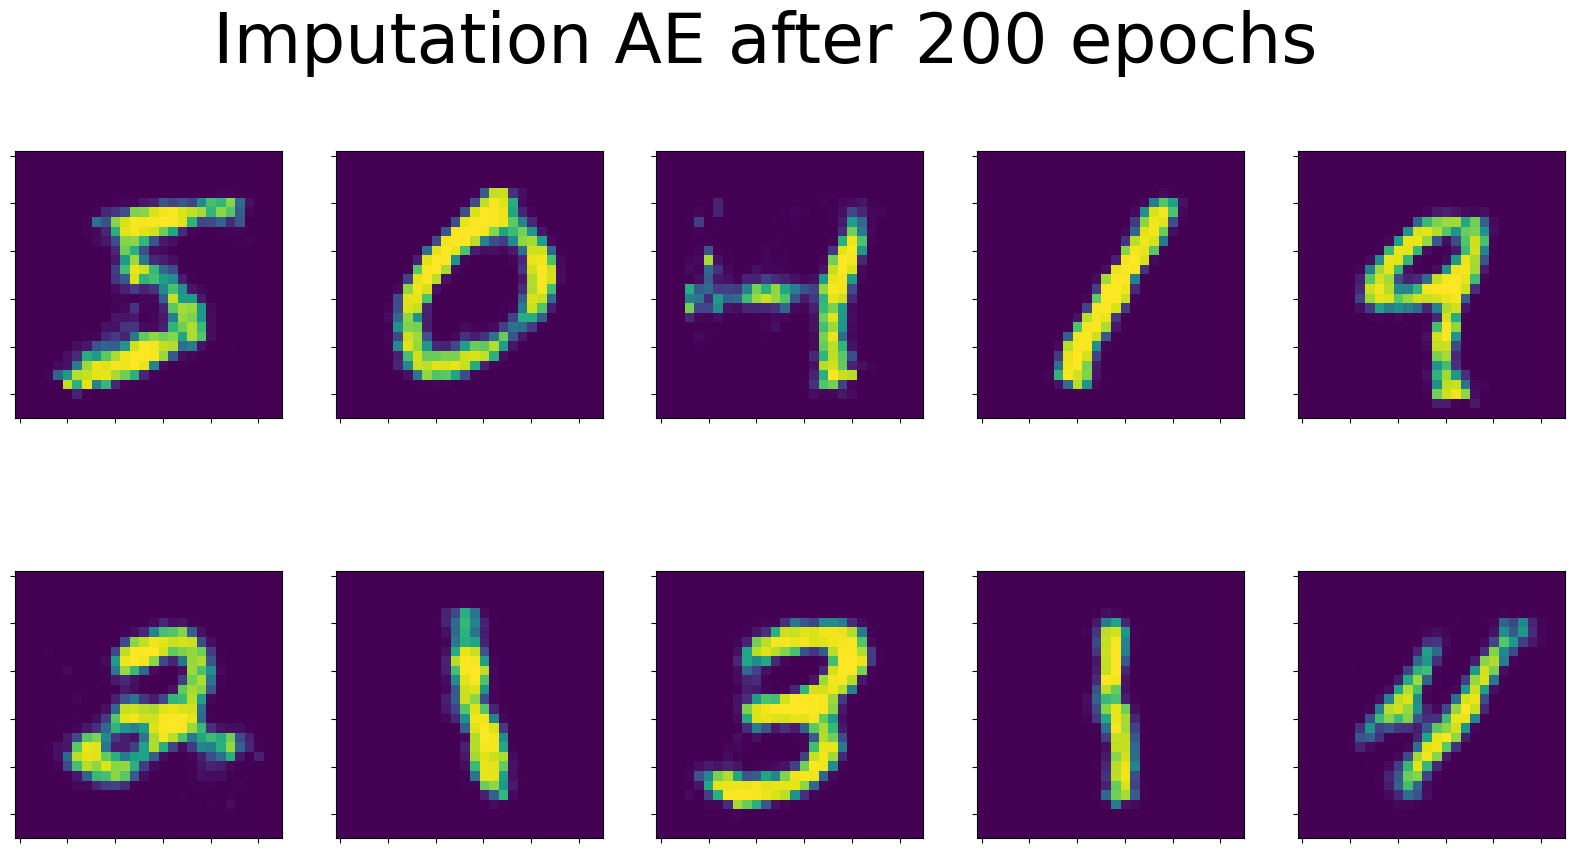

Epoch 300 out of 1000 ==== Loss: 0.061352573335170746


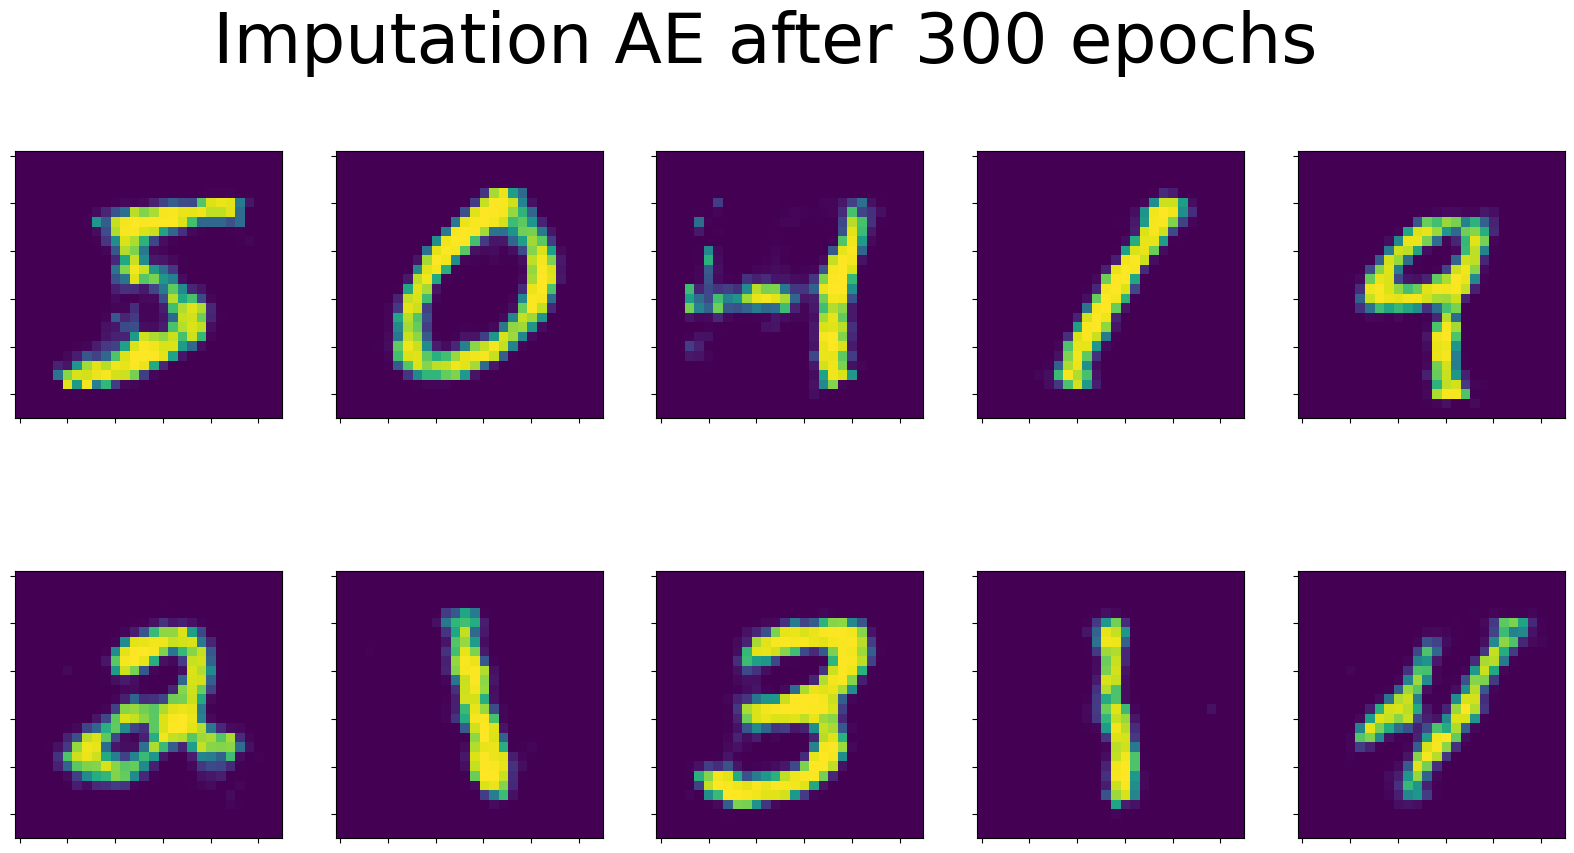

Epoch 400 out of 1000 ==== Loss: 0.06137911230325699


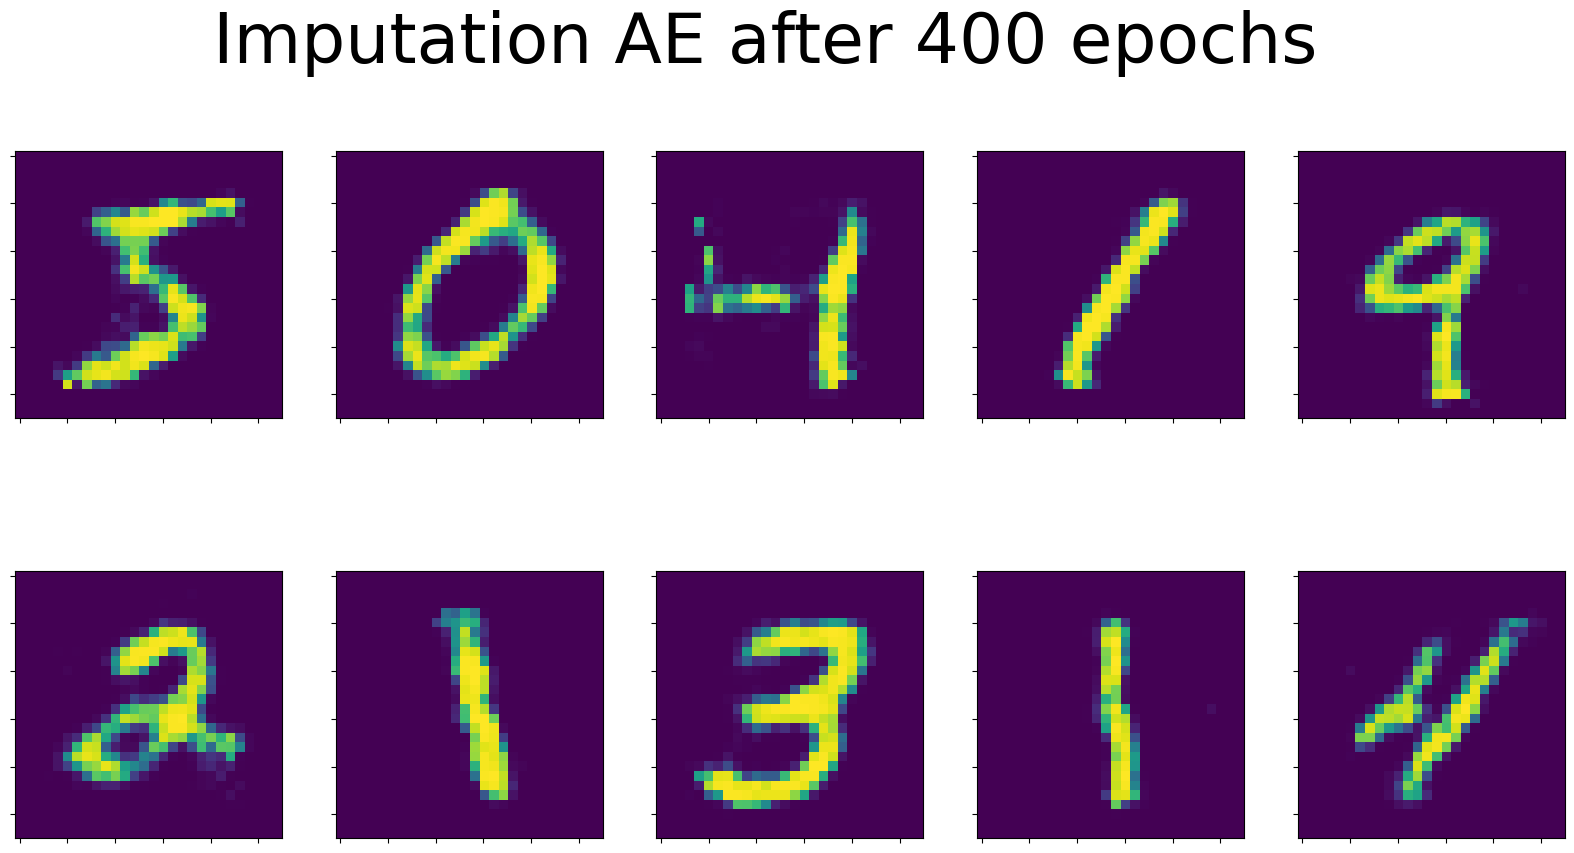

Epoch 500 out of 1000 ==== Loss: 0.061219409108161926


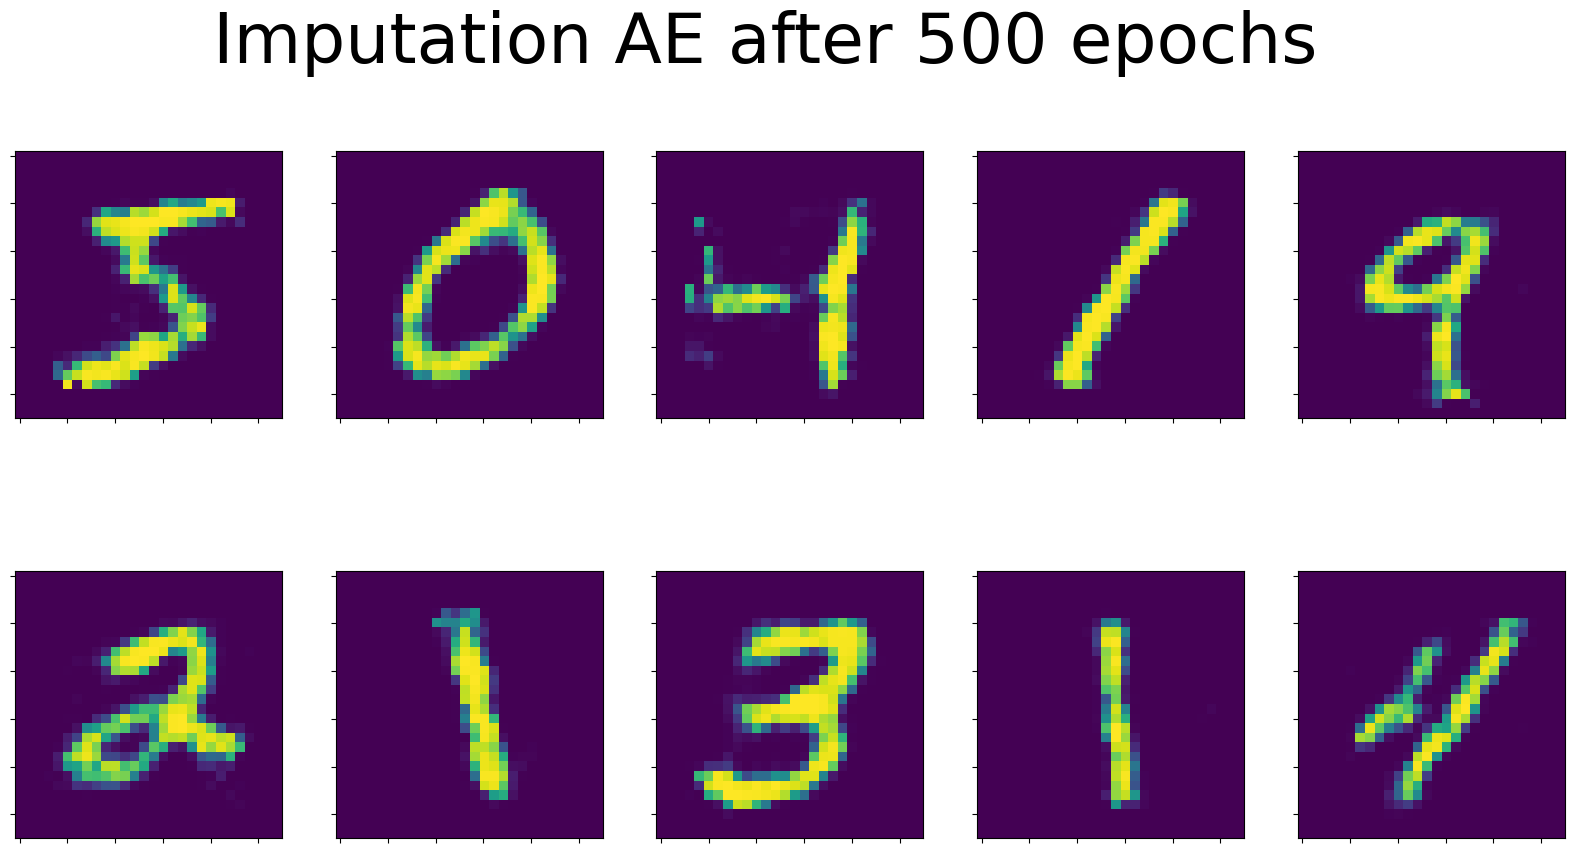

Epoch 600 out of 1000 ==== Loss: 0.06114570051431656


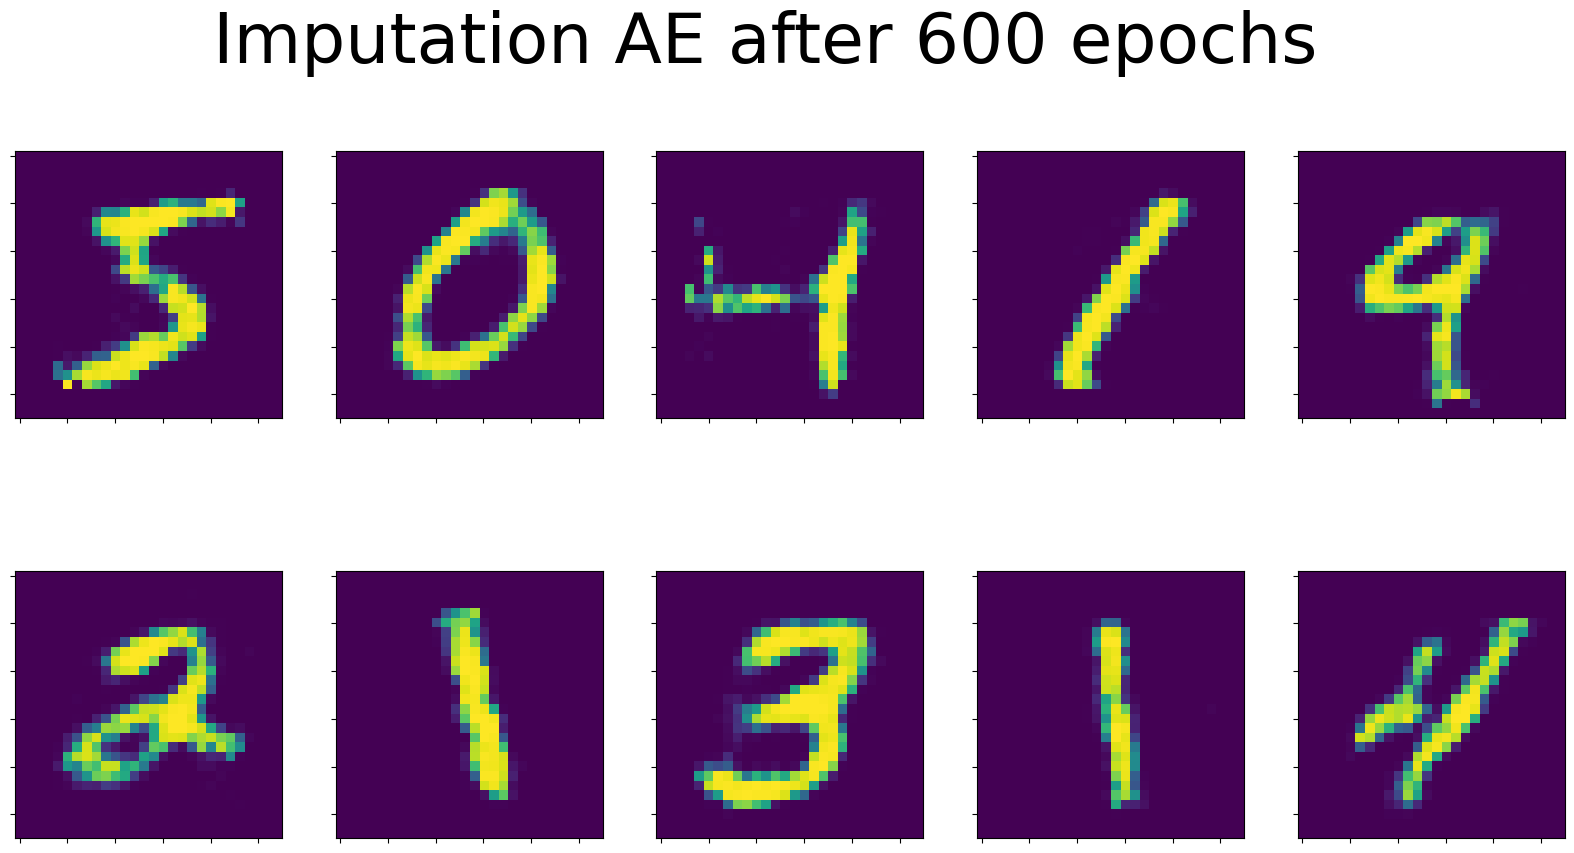

Epoch 700 out of 1000 ==== Loss: 0.06046753376722336


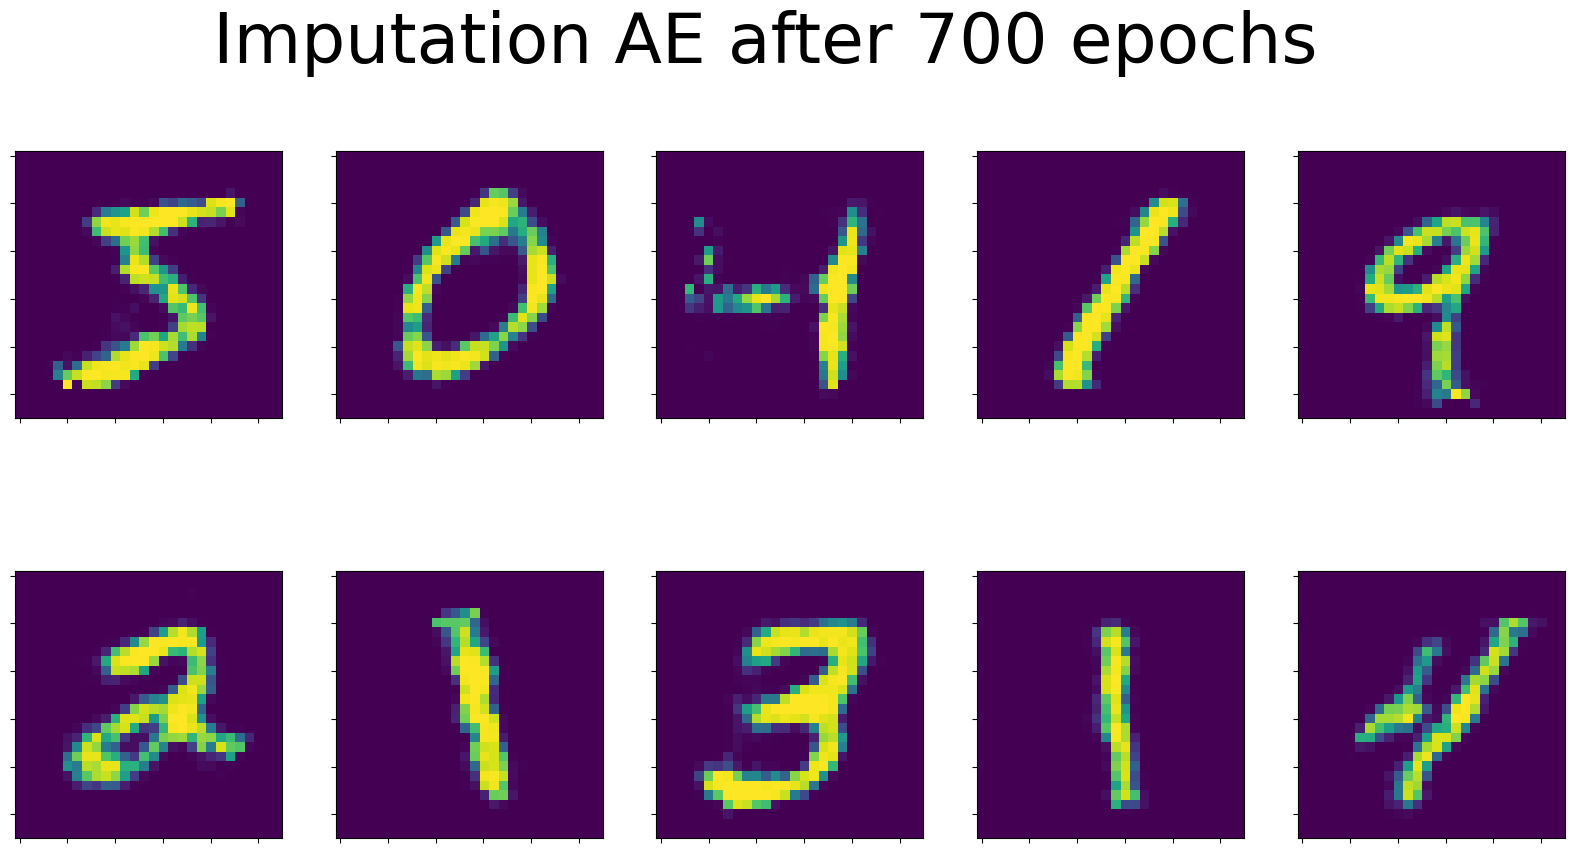

Epoch 800 out of 1000 ==== Loss: 0.06146842613816261


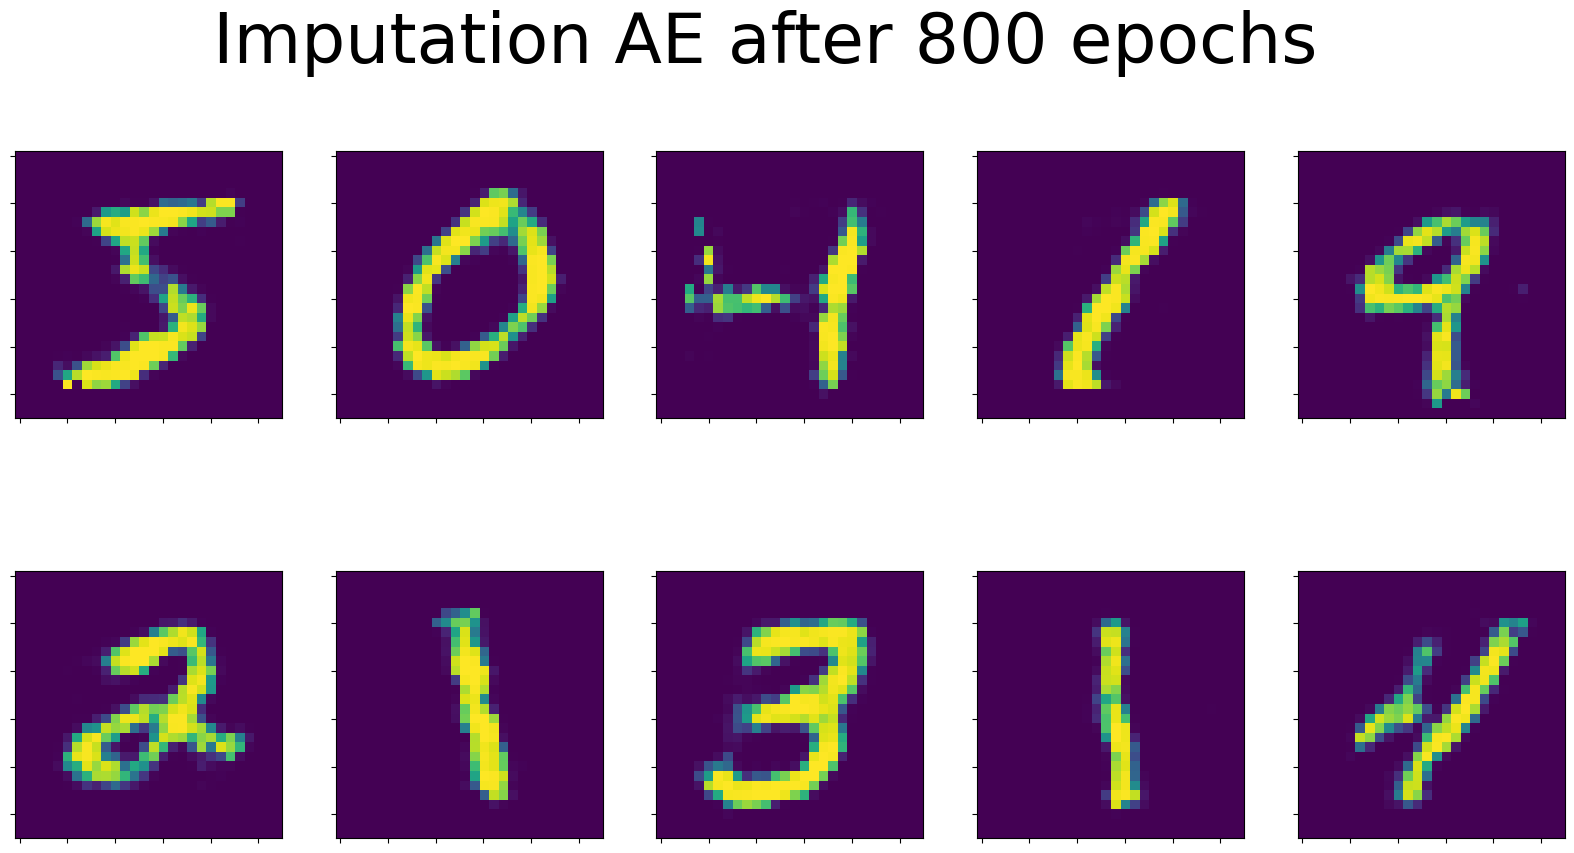

Epoch 900 out of 1000 ==== Loss: 0.061029307544231415


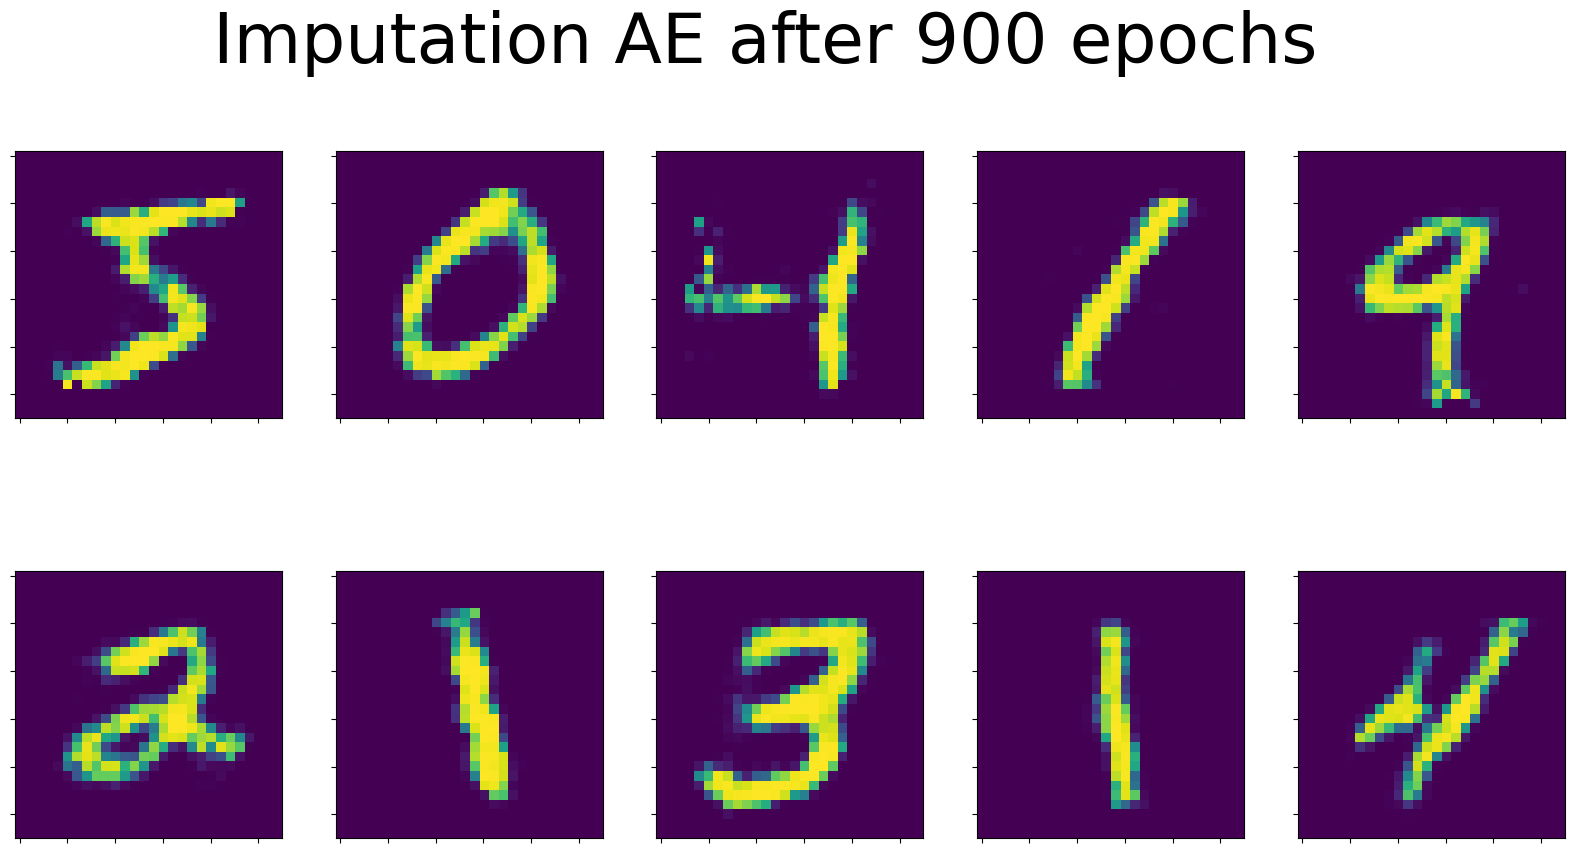

In [27]:
model.fit(data.data_train)

### You should get something like this at the end:

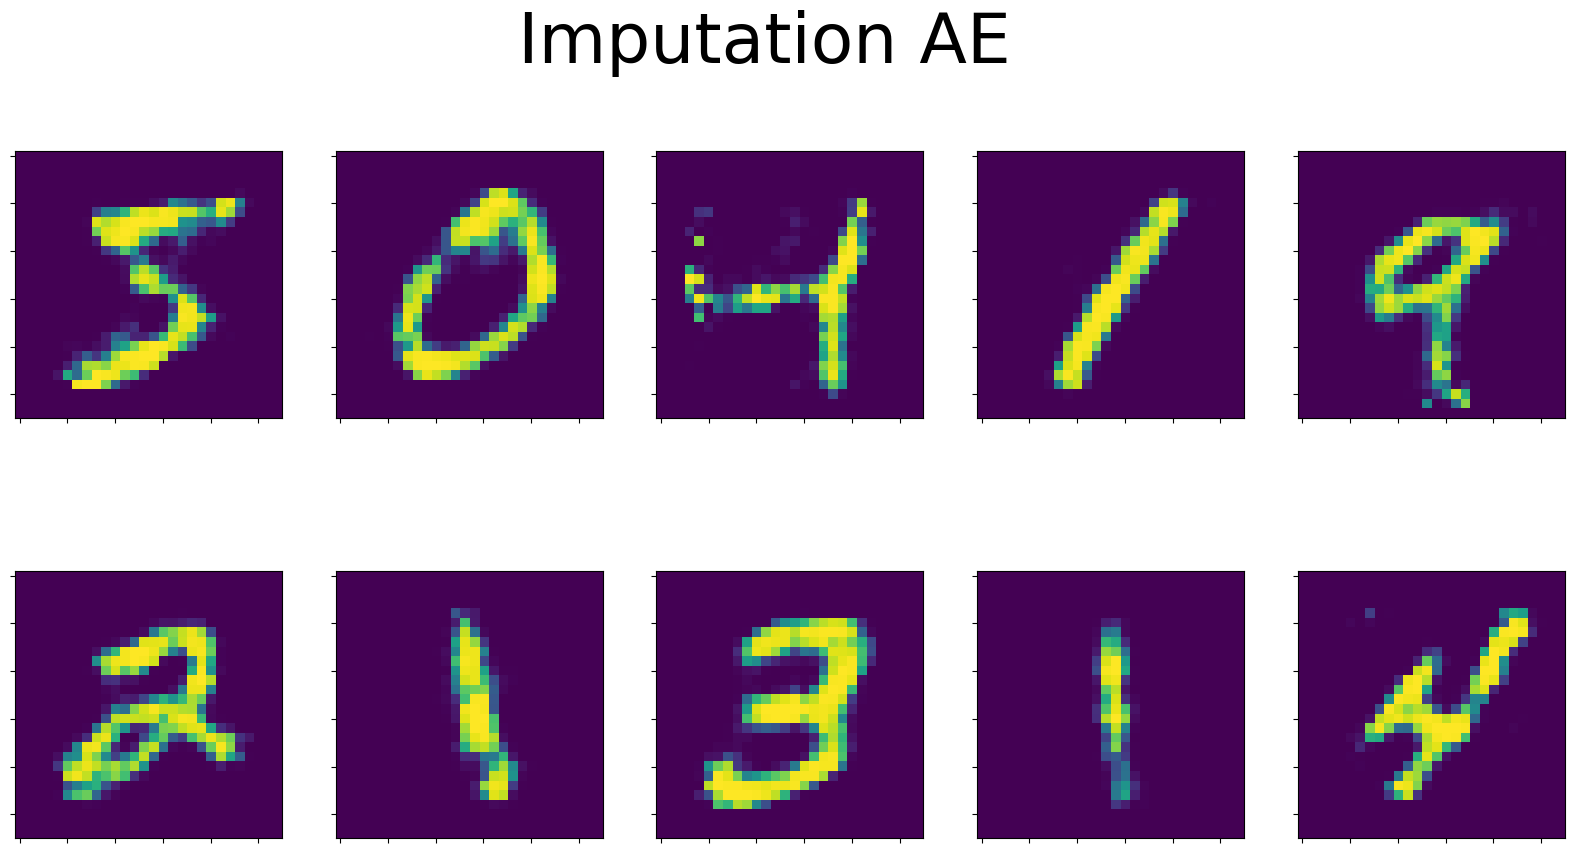

In [12]:
rec = model.transform(data.data_train)
plot_images(rec[:10], 5, 28, 28, title = "Imputation AE")

In [37]:
'''***Complute the MSE of the reconstruction using data.true_data and the output of the 3 sklearn methods and your AE***
'''
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
rec = imp.fit_transform(data.data_train)
print("MSE SimpleImputer mean: ", mean_squared_error(data.true_data, imp.transform(data.data_train)))



MSE SimpleImputer mean:  0.03988905268018987


In [38]:
imp = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")
rec = imp.fit_transform(data.data_train)
print("MSE SimpleImputer most frequent: ", mean_squared_error(data.true_data, imp.transform(data.data_train)))

MSE SimpleImputer most frequent:  0.06621812855730538


In [16]:
knn_imp = KNNImputer(n_neighbors=10, weights="uniform")
rec = knn_imp.fit_transform(data.data_train)
print("MSE KNN Imputer: ", mean_squared_error(data.true_data, knn_imp.transform(data.data_train)))

MSE KNN Imputer:  0.01788851392423637


In [39]:
print("MSE AE: ", mean_squared_error(data.true_data, model.transform(data.data_train)))

MSE AE:  0.014276310636263391
